In [1]:
import pandas as pd
import nltk
from nltk.metrics import agreement
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import masi_distance
import math
import numpy as np
from ast import literal_eval

In [2]:
hatebr = pd.read_csv('../data/hatebr_and_rationales.csv', converters={"rationales_offensive_1_normalized": \
                        lambda x: x.strip('[]').replace("'", "").split(", "),
                        "rationales_offensive_2_normalized": \
                        lambda x: x.strip('[]').replace("'", "").split(", ")})

### Rationales agreements

In [5]:
rationales_1 = hatebr['rationales_offensive_1_normalized'].tolist()[:3500]

In [6]:
rationales_2 = hatebr['rationales_offensive_2_normalized'].tolist()[:3500]

#### Span-level

In [7]:
def partial_match_score(a, b, threshold=0.5):
        
    intersection= list(set(a) & set(b))
    union = list(set().union(a, b))
    iou = len(intersection)/len(union)
    return iou >= threshold
    

def jaccard_index(annot1, annot2, partial_matches=True):
    
    jaccard = []
    
    for r1, r2 in zip(annot1, annot2):
        matches = 0
        
        for span1 in r1:
            for span2 in r2:
                
                if partial_matches:
                    if partial_match_score(span1.split(' '), span2.split(' '), threshold=0.5):
                        matches+=1
                else:
                    if span1 == span2:
                        matches+=1
        
        len_unique_spans = len(r1)+len(r2)-matches
        try:
            jaccard.append(matches/len_unique_spans)
        except:
            if r1 == r2:
                jaccard.append(matches/len(r1))
            elif r1 > r2:
                jaccard.append(matches/len(r1))
            else:
                jaccard.append(matches/len(r2))
        
    if partial_matches:
        print('Jaccard index span-level considering partial overlap: ', sum(jaccard)/len(annot1))
    
    else:
        print('Jaccard index span-level considering exact match: ', np.mean(jaccard))
    
    return jaccard
    

def precision(r1, r2, partial_matches=True):
    
    matches = 0
    
    for span1 in r1:
        for span2 in r2:
            
            if partial_matches:
                if partial_match_score(span1.split(' '), span2.split(' '), threshold=0.5):
                    matches += 1
            else:
                if span1 == span2:
                    matches += 1
    
    return matches/len(r1)

def recall(r1, r2, partial_matches=True):
    
    matches = 0
    
    for span1 in r1:
        for span2 in r2:
            
            if partial_matches: 
                if partial_match_score(span1.split(' '), span2.split(' '), threshold=0.5):
                    matches+=1
            
            else:
                if span1 == span2:
                    matches += 1
    
    return matches/len(r2)
    

def f1_score(annot1, annot2, partial_matches=True):
    
    prec = []
    rec = []
    f1 = []
    
    for r1, r2 in zip(annot1, annot2):
        
        p = precision(r1, r2, partial_matches)
        prec.append(p)
        r = recall(r1, r2, partial_matches)
        rec.append(r)
        
        if (p+r) > 0:
            f1.append(2*(p*r)/(p+r))
        else:
            f1.append(0)
    
    if partial_matches:
    
        print('Precision span-level considering partial overlap: ', sum(prec)/len(annot1))
        print('Recall span-level considering partial overlap: ', sum(rec)/len(annot1))
        print('F1-score span-level considering partial overlap: ', sum(f1)/len(annot1))
        
    else: 
        
        print('Precision span-level considering exact match: ', sum(prec)/len(annot1))
        print('Recall span-level considering exact match: ', sum(rec)/len(annot1))
        print('F1-score span-level considering exact match: ', sum(f1)/len(annot1))
        
    return f1

In [8]:
_ = f1_score(rationales_1, rationales_2, partial_matches=False)
print('\n')
f1_h = f1_score(rationales_1, rationales_2)

Precision span-level considering exact match:  0.49919296972868404
Recall span-level considering exact match:  0.5508122448979588
F1-score span-level considering exact match:  0.5131852286393663


Precision span-level considering partial overlap:  0.7155935501006935
Recall span-level considering partial overlap:  0.7598098639455784
F1-score span-level considering partial overlap:  0.7168473719680492


In [9]:
_ = jaccard_index(rationales_1, rationales_2, partial_matches=False)
print('\n')
jac_h = jaccard_index(rationales_1, rationales_2)

Jaccard index span-level considering exact match:  0.4697374340989003


Jaccard index span-level considering partial overlap:  0.674562419326705


In [10]:
def f1_score_token_level(annot1, annot2):
    f1_score = []
    recs = []
    precs = []
    for r1, r2 in zip(annot1, annot2):
        
        a = ' '.join(r1).split(' ')
        b = ' '.join(r2).split(' ')
        
        precision = len(list(set(a) & set(b)))/len(a) if len(a) > 0 else 0
        precs.append(precision)
        recall = len(list(set(a) & set(b)))/len(b) if len(b) > 0 else 0
        recs.append(recall)
        
        if recall+precision > 0:
            f1_score.append(2*((recall*precision)/(recall+precision)))
    
    
    print('Precision token-level: ', sum(precs)/len(annot1))
    print('Recall token-level: ', sum(recs)/len(annot1))
    print('F1-score token-level: ', sum(f1_score)/len(annot1))
    

In [11]:
f1_score_token_level(rationales_1, rationales_2)

Precision token-level:  0.7048811125875489
Recall token-level:  0.9087454710637196
F1-score token-level:  0.7404556852785749


In [12]:
def jaccard_index_token_level(annot1, annot2):
    
    jaccard = []
    
    for r1, r2 in zip(annot1, annot2):
        
        a = ' '.join(r1).split(' ')
        b = ' '.join(r2).split(' ')
        
        intersection= list(set(a) & set(b))
        union = list(set().union(a, b))
        jaccard.append(len(intersection)/len(union))
        
    print('Jaccard index token-level: ', sum(jaccard)/len(annot1))

In [13]:
jaccard_index_token_level(rationales_1, rationales_2)

Jaccard index token-level:  0.6720534990804783


Some Rationales Statistics

In [14]:
count = 0
terms = {}
for r in rationales_1:
    list_words = ' '.join(r).split(' ')
    count += len(list_words)
    for w in list_words:
        try:
            terms[w] += 1
        except:
            terms[w] = 1
    
    
count/len(rationales_1)

7.725142857142857

In [15]:
count = 0
terms_f = {}
for r in rationales_2:
    list_words = ' '.join(r).split(' ')
    count += len(list_words)
    for w in list_words:
        try:
            terms_f[w] += 1
        except:
            terms_f[w] = 1
    
count/len(rationales_2)

5.140571428571429

In [16]:
count = 0
for e, r in enumerate(hatebr['normalized_text']):
    if e >= 3500:
        break
    count += len(r.split(' '))
    
count/len(rationales_1)

15.272857142857143

In [17]:
spans_r1 = []
spans_r2 = []
for r1, r2 in zip(rationales_1, rationales_2):
    for s1 in r1:
        spans_r1.append(len(s1))
    for s2 in r2:
        spans_r2.append(len(s2))

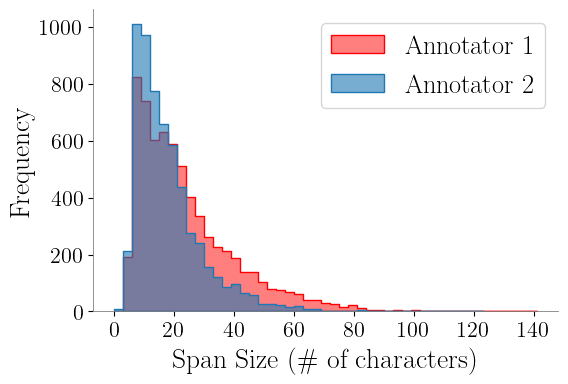

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc 

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
plt.rcParams['savefig.dpi'] = 300  # Ensures high-quality output
plt.rcParams['figure.dpi'] = 100

plt.figure()
sns.histplot(data=spans_r1, color='red', binwidth=3, element='step', label='Annotator 1', alpha=0.5)
sns.histplot(data=spans_r2, color='tab:blue', binwidth=3,  element='step', label = 'Annotator 2', alpha=0.6)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Span Size (\# of characters)', fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=19)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.gca().spines['left'].set_linewidth(0.6)
plt.gca().spines['bottom'].set_linewidth(0.6)

plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.savefig('histogram.jpg', bbox_inches = 'tight')
plt.show()

Compare with random rationales

In [36]:
import random
random1 = []
for e, (r, t) in enumerate(zip(rationales_1, hatebr['normalized_text'])):
    r_length = len(' '.join(r).split(' '))
    c_length = len(t.split(' '))
    try:
        random1.append([t.split(' ')[i] for i in random.sample(range(0, c_length), r_length)])
    except:
        if r_length > c_length:
            r_length = c_length
            random1.append([t.split(' ')[i] for i in random.sample(range(0, c_length), r_length)])

In [37]:
random2 = []
for e, (r, t) in enumerate(zip(rationales_2, hatebr['normalized_text'])):
    r_length = len(' '.join(r).split(' '))
    c_length = len(t.split(' '))
    try:
        random2.append([t.split(' ')[i] for i in random.sample(range(0, c_length), r_length)])
    except:
        if r_length > c_length:
            r_length = c_length
            random2.append([t.split(' ')[i] for i in random.sample(range(0, c_length), r_length)])

In [38]:
f1_r = f1_score(random1, random2)

Precision span-level considering partial overlap:  0.5459101976884037
Recall span-level considering partial overlap:  0.7089603117240129
F1-score span-level considering partial overlap:  0.573538142016217


In [39]:
jac_r = jaccard_index(random1, random2)

Jaccard index span-level considering partial overlap:  0.48547060152911553
